<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pickle" data-toc-modified-id="Pickle-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pickle</a></span><ul class="toc-item"><li><span><a href="#Animals-Subset" data-toc-modified-id="Animals-Subset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Animals Subset</a></span></li><li><span><a href="#Everything" data-toc-modified-id="Everything-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Everything</a></span></li></ul></li><li><span><a href="#DataLoaders" data-toc-modified-id="DataLoaders-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>DataLoaders</a></span></li><li><span><a href="#2018.9" data-toc-modified-id="2018.9-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>2018.9</a></span></li></ul></div>

# Pickle

## Animals Subset

**Label subset:**

In [ ]:
def flatten(l):
    def _recur(l,res):
        for o in l:
            if isinstance(o,L): _recur(o,res)
            if isinstance(o,list): _recur(o,res)
            else: res.append(o)
        return res
    return _recur(l,L())  
flat_lbls = flatten(lbls)
def get_count(lbl): return len(flat_lbls.filter(lambda x: x==lbl))
sorted_lbls = sorted(flat_lbls.unique(), key=get_count, reverse=True)
[(l, get_count(l)) for l in sorted_lbls][:25]

[('person', 31659),
 ('giraffe', 3722),
 ('cat', 3467),
 ('car', 3278),
 ('toilet', 3209),
 ('zebra', 3015),
 ('clock', 2998),
 ('dog', 2992),
 ('train', 2764),
 ('sink', 2754),
 ('bird', 2704),
 ('surfboard', 2685),
 ('bed', 2663),
 ('airplane', 2648),
 ('elephant', 2377),
 ('horse', 2212),
 ('bench', 2144),
 ('chair', 2093),
 ('dining table', 2092),
 ('truck', 1959),
 ('skateboard', 1935),
 ('skis', 1860),
 ('cow', 1841),
 ('tennis racket', 1808),
 ('cell phone', 1746)]

In [ ]:
lbl_subset = ['giraffe','zebra','dog','cat','bird','elephant','horse','cow']

**Animals pickle:**

In [ ]:
from fastai.vision.all import *

# paths
path = Path('/home/rory/data/coco2017')
train_im_dir, valid_im_dir = 'train2017', 'val2017'
train_json = 'annotations/instances_train2017.json'
valid_json = 'annotations/instances_val2017.json'
animals = ['giraffe','cat','zebra','dog','bird','elephant','horse','cow']

# get items & annos
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_files, train_annos = get_annos(path, train_json, train_im_dir)
valid_files, valid_annos = get_annos(path, valid_json, valid_im_dir)
annos = train_annos + valid_annos
bboxes = L(L(b) for b,l in annos)
lbls   = L(L(l) for b,l in annos)

# animals
ani_subset = ['giraffe','cat','zebra','dog','bird','elephant','horse','cow']
ani_idxs   = L(L(o in ani_subset for o in l) for l in lbls)
ani_lbls   = L(o[i] for o,i in zip(lbls,ani_idxs))
ani_bboxes = L(o[i] for o,i in zip(bboxes,ani_idxs))
ani_ins    = L(len(l) for l in ani_lbls)

# create df and pkl
df = pd.DataFrame({
    "path": train_files + valid_files,
    "lbl" : ani_lbls,
    "bbox": ani_bboxes,
    "ins" : ani_ins
    })
df.to_pickle(path/'20201027_coco_animals_df.pkl')

## Everything

In [ ]:
from fastai.vision.all import *

# paths
path = Path('/home/rory/data/coco2017')
train_im_dir, valid_im_dir = 'train2017', 'val2017'
train_json = 'annotations/instances_train2017.json'
valid_json = 'annotations/instances_val2017.json'
animals = ['giraffe','cat','zebra','dog','bird','elephant','horse','cow']

# get items & annos
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_files, train_annos = get_annos(path, train_json, train_im_dir)
valid_files, valid_annos = get_annos(path, valid_json, valid_im_dir)
annos = train_annos + valid_annos

# create df and pkl
df = pd.DataFrame({
    "path": train_files + valid_files,
    "lbl":  [a[1] for a in annos],
    "bbox": [a[0] for a in annos],
    "is_valid": [0]*len(train_files) + [1]*len(valid_files),
    "n_items": L(len(l) for l in lbls)
    })
df.to_pickle(path/'20201027_coco_df.pkl')

In [ ]:
df.head(1)

,path,lbl,bbox,is_valid,n_items
0,/home/rory/data/coco2017/train2017/000000391895.jpg,"[motorcycle, person, person, bicycle]","[[359.17, 146.17, 471.62, 359.74], [339.88, 22.16, 493.76, 322.89000000000004], [471.64, 172.82, 507.56, 220.92], [486.01, 183.31, 516.64, 218.29]]",0,4


# DataLoaders

In [ ]:
from fastai.vision.all import *


### Params ###
im_size    = 224
batch_size = 64
path       = Path('/home/rory/data/coco2017')
valid_pct  = .10


### Items ###
df = pd.read_pickle(path/'coco_df.pkl')
df = df.query('n_items < 10')
def get_cols(df,cols): return L(L(df[c].to_list()) for c in cols)
paths, bboxes, lbls  = get_cols(df, ['path', 'bbox', 'lbl'])
p2b = {p:b for p,b in zip(paths,bboxes)}
p2l = {p:l for p,l in zip(paths,lbls)}
def get_bbox(p): return p2b[p]
def get_lbl(p):  return p2l[p]


### DataBlock & DataLoaders ###
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
    get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(valid_pct),
    item_tfms=Resize(im_size, method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    n_inp=1)
dls = db.dataloaders(paths)

# 2018.9

**Architecture**

In [ ]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(  np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
# anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchors = Tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1))

In [ ]:
# 42:33
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

In [ ]:
# 42:33
def flatten_conv(x,k): return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2) # loss func expects flat tensor

In [ ]:
# 42:33
class OutConv(nn.Module):
    # output is two conv layers (instead of one linear layer)
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, 4*k, 3, padding=1)              # bbs
        self.oconv2 = nn.Conv2d(nin, len(dls.vocab)*k, 3, padding=1) # lbls
        self.oconv2.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

In [ ]:
# 42:00
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

head_reg4 = SSD_Head(k, -3.)
body = create_body(resnet34, pretrained=True)
class custom_module(Module):
    
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))
mod = custom_module(body, head_reg4)
learner = Learner(dls, mod)

**Loss Function**

In [ ]:
def show_bb(im,bb,lbl=None,sz=224,ctx=None,figsize=5,**kwargs):
    
    if isinstance(figsize,int): figsize = (figsize,figsize)
    bboxes = TensorBBox((bb+1)*sz//2)
    
    if lbl!=None:
        try: labels = dls.vocab[lbl]
        except: labels = lbl
        bboxes = LabeledBBox(bboxes, labels)
        
    if ctx==None: ctx = show_image(im, figsize=figsize, **kwargs);
    else: show_image(im, figsize=figsize, ctx=ctx, **kwargs);
    return bboxes.show(ctx=ctx);

In [ ]:
# ims, bbs, lbls
batch = next(iter(dls.valid))
learner.model.eval()
preds = learner.model(batch[0].cpu())
pred_bboxes, pred_lbls = preds

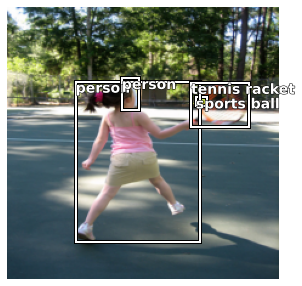

In [ ]:
idx=0
pred_bbox, pred_lbl = pred_bboxes[idx], pred_lbls[idx]
dec_batch = dls.decode(batch)
dec_im = dec_batch[0][idx]
bbox, lbl = batch[1][idx], batch[2][idx]
show_bb(dec_im, bbox, lbl)

<AxesSubplot:>

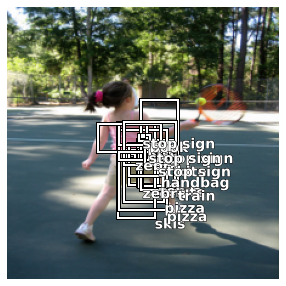

In [ ]:
show_bb(dec_im, pred_bbox, pred_lbl.max(1)[1])

**IOU:**

In [ ]:
# works for two bbs, but not for lists of bbs. I want this: iou(bbox, anchor_bbs)
def iou(b1,b2):
    xt,yt = max(b1[0], b2[0]), max(b1[1], b2[1])    # top-left
    xb,yb = min(b1[2], b2[2]), min(b1[3], b2[3])    # bottom-right
    inter = max(0, abs(xt-xb)) * max(0, abs(yt-yb)) # intersection area
    a1 = (b1[2]-b1[0])*(b1[3]-b1[1])                # b1 area
    a2 = (b2[2]-b2[0])*(b2[3]-b2[1])                # b2 area
    return inter/(a1+a2-inter)

<AxesSubplot:>

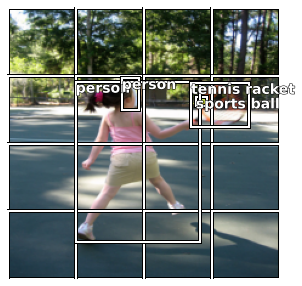

In [ ]:
# anchors are from 0,1 instead of -1,1
anchor_bbs = torch.stack([2*(anchors[:,0]-anchors[:,3]/2)-1,
                          2*(anchors[:,1]-anchors[:,2]/2)-1,
                          2*(anchors[:,0]+anchors[:,3]/2),
                          2*(anchors[:,1]+anchors[:,2]/2)], axis=1)
# show anchorbbs and targbbs together
ctx = show_bb(dec_im, anchor_bbs)
show_bb(dec_im, bbox, lbl, ctx=ctx)

In [ ]:
iou(bbox.cpu(),anchor_bbs) # left off here

RuntimeError: Boolean value of Tensor with more than one value is ambiguous